# Data selection notes

Let's confirm that we can reproduce the NGC 1333 results from 2014 to some degree.

~(I'm looking at ["official_star_counter" from wuvsars-orion](https://github.com/tomr-stargazer/wuvars-orion/blob/master/official_star_counter.py).)~ Actually I was looking at the equivalent perseus-star-counter.


### First: Can we, like, re-run wuvsars-perseus's official star counter?

official star counter lives here:
/Users/tsrice/Documents/Code/wuvars-perseus/perseus_star_counter.py


In [2]:
%run /Users/tsrice/Documents/Code/wuvars-perseus/perseus_star_counter.py

Auto-detected table type: fits
Auto-detected table type: fits
Number of detected sources in the dataset:
21885
Number of stars that meet absolute minimum considerations for valid data:
(i.e., have at least 50 recorded observations in at least one band)
13558
Maximum possible number of variables (Stetson > 0.5) : 647
Number of stars automatically classed as variables: 97
Number of stars that have the data quality for auto-classification: 3126

Number of probably-variable stars requiring subjective verification due to imperfect data quality: 550

Number of STRICT autovariables: 59
Number of STRICT autocandidates: 2147

 Q: Statistically, what fraction of our stars are variables?
 A: 2.75%, drawn from the tightest-controlled sample;
    3.10%, drawn from a looser sample.

Number of possible variables with detected periods: 101
Number of autovariables that are periodic: 53
Number of STRICT autovariables that are periodic: 37
Number of possible periodic variables requiring subjective valida

```
(As a check, I looked up what the star counter used to say... this is what I wrote on May 30, 2014. Some very slight changes were introduced to the code since this was written, and those changes are worthwhile.)

Number of detected sources in the dataset:
21885
Number of stars that meet absolute minimum considerations for valid data:
(i.e., have at least 50 recorded observations in at least one band)
13558
Maximum possible number of variables (Stetson > 0.5) : 647
Number of stars automatically classed as variables: 98
Number of stars that have the data quality for auto-classification: 3132

Number of probably-variable stars requiring subjective verification due to imperfect data quality: 549

Number of STRICT autovariables: 60
Number of STRICT autocandidates: 2152

 Q: Statistically, what fraction of our stars are variables?
 A: 2.79%, drawn from the tightest-controlled sample;
    3.13%, drawn from a looser sample.

Number of possible variables with detected periods: 96
Number of autovariables that are periodic: 48
Number of STRICT autovariables that are periodic: 32
Number of possible periodic variables requiring subjective validation: 48

 Q: Statistically, what fraction of our variables are periodic?
 A: 53.33%, drawn from the tightest-controlled sample;
    48.98%, drawn from a looser sample.

 Q: What fraction of stars in this dataset are periodic variables?
 A: 1.49%, drawn from the tightest-controlled sample;
    1.53%, drawn from a looser sample.
    ```
    


2147
59


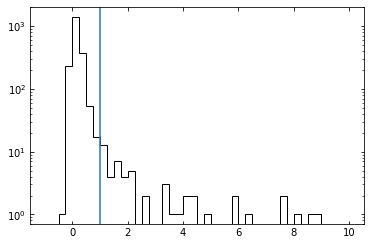

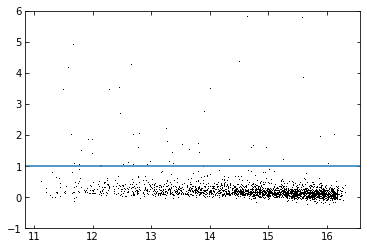

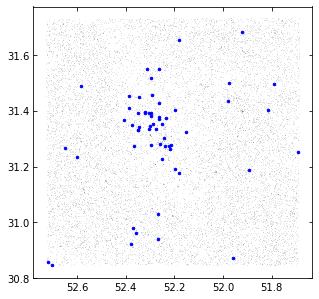

In [83]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True

# let's inspect a histogram of Stetson values.
plt.semilogy()
plt.hist(spread.Stetson[cand_case1], range=[-1, 10], bins=44,  color='k', histtype='step')
plt.axvline(1)

print(np.sum(cand_case1))
print(np.sum(case1))

plt.figure()
plt.plot(spread.h_mean[cand_case1], spread.Stetson[cand_case1], "k,")
plt.ylim(-1,6)
plt.axhline(1)
plt.plot()

fig = plt.figure(figsize=(5,5))
plt.plot(np.degrees(minimum.RA), np.degrees(minimum.DEC), 'k,', alpha=0.1)
plt.plot(np.degrees(maxvars.RA[case1]), np.degrees(maxvars.DEC[case1]), 'b.', ms=5)
plt.gca().invert_xaxis()


# Question 1: 

Given that we've shifted away from old "summary spreadsheet" code from ~2012 (which used ATpy internally) to new code which uses Pandas internally (for a huge boost in performance, maintainability/clarity, and compatibility with Python 3), can we reproduce the numbers from Table 1 of Rice et al 2015? In other words, **can we verify that the new code produces the same output as the old code**, given the same photometric data and the same definitions for "quality bins"?

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table


In [26]:
# Let's re-implement the above for WSERV5, in my new reduction.

spreadsheet_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"
wserv_ids = [7]
wserv = wserv_ids[0]
# for wserv in wserv_ids[::-1]:
    
print(f"\n   WSERV{wserv}: \n")

spreadsheet_path = os.path.join(
    spreadsheet_root,
    f"wserv{str(wserv)}",
    f"WSERV{str(wserv)}_graded_clipped0.95_scrubbed0.1_dusted0.5_summary_spreadsheet.h5",
)
if wserv==5:
    spreadsheet_path = os.path.join(
        spreadsheet_root, 
        "wserv5_v2012",
        f"WSERV{str(wserv)}_fdece_graded_clipped0.8_scrubbed0.1_dusted0.5_summary_spreadsheet.h5")
    print(f"WSERV5: {spreadsheet_path}")

ds = pd.read_hdf(spreadsheet_path, key='table')

q0 = (
    (ds["count"]["N_J"] >= 50)
    | (ds["count"]["N_H"] >= 50)
    | (ds["count"]["N_K"] >= 50)
)

print("")
print("Total detected sources:", len(ds))
print("Total sources with at least 50 obs in one band:", len(ds[q0]))

q1_old = (
    (
        (ds["count"]["N_J"] >= 50)
        & (ds["count"]["N_J"] <= 135)
        & (ds["mean"]["JAPERMAG3"] > 11)
        & (ds["mean"]["JAPERMAG3"] < 17)
        & (ds["count"]["N_J_info"] == 0)
    )
    | (
        (ds["count"]["N_H"] >= 50)
        & (ds["count"]["N_H"] <= 130)
        & (ds["mean"]["HAPERMAG3"] > 11)
        & (ds["mean"]["HAPERMAG3"] < 16.7)
        & (ds["count"]["N_H_info"] == 0)
    )
    | (
        (ds["count"]["N_K"] >= 50)
        & (ds["count"]["N_K"] <= 150)
        & (ds["mean"]["KAPERMAG3"] > 11)
        & (ds["mean"]["KAPERMAG3"] < 16)
        & (ds["count"]["N_K_info"] == 0)
    )
)     & (ds["median"]["PSTAR"] > 0.75)

q1 = q1_old

print("Total Q=1 sources:", len(ds[q1]))

q2_old = (
    (
        (ds["count"]["N_J"] >= 50)
        & (ds["count"]["N_J"] <= 135)
        & (ds["mean"]["JAPERMAG3"] > 11)
        & (ds["mean"]["JAPERMAG3"] < 17)
        & (ds["count"]["N_J_info"] == 0)
    )
    & (
        (ds["count"]["N_H"] >= 50)
        & (ds["count"]["N_H"] <= 130)
        & (ds["mean"]["HAPERMAG3"] > 11)
        & (ds["mean"]["HAPERMAG3"] < 16.7)
        & (ds["count"]["N_H_info"] == 0)
    )
    & (
        (ds["count"]["N_K"] >= 50)
        & (ds["count"]["N_K"] <= 150)
        & (ds["mean"]["KAPERMAG3"] > 11)
        & (ds["mean"]["KAPERMAG3"] < 16)
        & (ds["count"]["N_K_info"] == 0)
    )
) & (ds["median"]["PSTAR"] > 0.75)

q2 = q2_old

print("Total Q=2 sources:", len(ds[q2]))


   WSERV7: 


Total detected sources: 21885
Total sources with at least 50 obs in one band: 13563
Total Q=1 sources: 3125
Total Q=2 sources: 2147


In [27]:
print(len(minimum.SOURCEID))
print(len(ds[q0]))

# This is how you figure out the members of one set that are not members of the other set
np.sum(~np.in1d(ds[q0].index, minimum.SOURCEID))

new_sourceids = ds[q0].index[~np.in1d(ds[q0].index, minimum.SOURCEID)]

print(new_sourceids)

old_sourceids = minimum.SOURCEID[~np.in1d(minimum.SOURCEID, ds[q0].index)]

print(old_sourceids)

13558
13563
Int64Index([44508746102166, 44508746102693, 44508746105672, 44508746106313,
            44508746109034, 44508746109476],
           dtype='int64', name='SOURCEID')
[44508746107539]


In [11]:
from IPython.display import display
pd.options.display.max_columns = None
display(ds[q0][~np.in1d(ds[q0].index, minimum.SOURCEID)]['count'])

,N_J,N_H,N_K,N_J_good,N_H_good,N_K_good,N_J_info,N_H_info,N_K_info,N_J_warn,N_H_warn,N_K_warn,N_J_severe,N_H_severe,N_K_severe
SOURCEID,,,,,,,,,,,,,,,
44508746102166,0.0,0.0,50.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44508746102693,18.0,47.0,50.0,18.0,47.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44508746105672,0.0,23.0,50.0,0.0,23.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44508746106313,0.0,1.0,50.0,0.0,1.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44508746109034,0.0,0.0,50.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44508746109476,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
print(len(autocan_true.SOURCEID))
print(len(ds[q1]))

# This is how you figure out the members of one set that are not members of the other set
np.sum(~np.in1d(ds[q1].index, autocan_true.SOURCEID))

new_sourceids_q1 = ds[q1].index[~np.in1d(ds[q1].index, autocan_true.SOURCEID)]

print(new_sourceids_q1)

old_sourceids_q1 = autocan_true.SOURCEID[~np.in1d(autocan_true.SOURCEID, ds[q1].index)]

print(old_sourceids_q1)

3126
3125
Int64Index([], dtype='int64', name='SOURCEID')
[44508746102349]


In [30]:
ds[np.in1d(ds.index, old_sourceids_q1)]['count']

,N_J,N_H,N_K,N_J_good,N_H_good,N_K_good,N_J_info,N_H_info,N_K_info,N_J_warn,N_H_warn,N_K_warn,N_J_severe,N_H_severe,N_K_severe
SOURCEID,,,,,,,,,,,,,,,
44508746102349,98.0,91.0,98.0,95.0,88.0,97.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
print(len(autocan_strict.SOURCEID))
print(len(ds[q2]))

# This is how you figure out the members of one set that are not members of the other set
np.sum(~np.in1d(ds[q2].index, autocan_strict.SOURCEID))

new_sourceids_q2 = ds[q2].index[~np.in1d(ds[q2].index, autocan_strict.SOURCEID)]

print(new_sourceids_q2)

old_sourceids_q2 = autocan_strict.SOURCEID[~np.in1d(autocan_strict.SOURCEID, ds[q2].index)]

print(old_sourceids_q2)

2147
2147
Int64Index([], dtype='int64', name='SOURCEID')
[]


# Answer to Question 1: Perseus 

Okay, the good: we are picking up **exactly** the same number of detected sources for WSERV7 as before. (21885)


**Now we have 13563 (vs. 13558) Q=0 sources in this dataset**. This means we are reproducing, almost exactly, the output of the older code, and can be confident that, moving forward (as we apply this code to the other datasets), we are bringing forward our experience-tested criteria. Mostly.


I'm able to get OFF BY ONE 3125 Q=1 stars (vs. 3126) and *exactly* 2147 Q=2 stars with the new selecting code. This is good.


I suspect the single-digit number differences in these reflect extremely minor differences in the cleaning procedure as it ran between py2 and py3 (like, integer division v float division issues??)

# Quick sanity check:
Are we picking up the *exact same* 14728 stars?

In [6]:
print(len(minimum.SOURCEID))
print(len(ds[q0]))

# This is how you figure out the members of one set that are not members of the other set
np.sum(~np.in1d(ds[q0].index, minimum.SOURCEID))

new_sourceids = ds[q0].index[~np.in1d(ds[q0].index, minimum.SOURCEID)]

print(new_sourceids)

old_sourceids = minimum.SOURCEID[~np.in1d(minimum.SOURCEID, ds[q0].index)]

print(old_sourceids)

14728
14728
Int64Index([], dtype='int64', name='SOURCEID')
[]


# Answer to quick sanity check: Yes, the lists are identical.

# Some diagnostics

Let's make a map and some histograms of where the 13,558 Q=0 stars are and what their brightness distribution looks like.


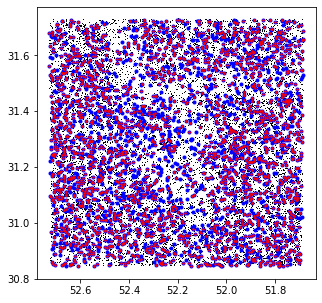

In [57]:
plt.figure(figsize=(5,5))
plt.plot(np.degrees(ds[q0]['mean']['RA']), np.degrees(ds[q0]['mean']['DEC']), 'k,')
plt.plot(np.degrees(ds[q1]['mean']['RA']), np.degrees(ds[q1]['mean']['DEC']), 'b.')
plt.plot(np.degrees(ds[q2]['mean']['RA']), np.degrees(ds[q2]['mean']['DEC']), 'r.', ms=3)

plt.gca().invert_xaxis()

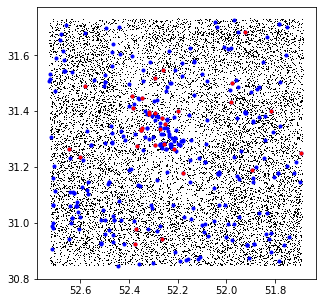

In [58]:
plt.figure(figsize=(5,5))

var = ds['variability']['Stetson_JHK'] > 2

v2 = q2 & var
v0 = q0 & var

plt.plot(np.degrees(ds[q0]['mean']['RA']), np.degrees(ds[q0]['mean']['DEC']), 'k,')
plt.plot(np.degrees(ds[v0]['mean']['RA']), np.degrees(ds[v0]['mean']['DEC']), 'b.')
plt.plot(np.degrees(ds[v2]['mean']['RA']), np.degrees(ds[v2]['mean']['DEC']), 'r.')

plt.gca().invert_xaxis()

[]

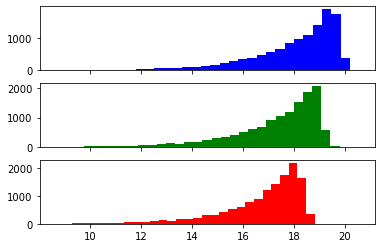

In [34]:
fig, axes = plt.subplots(nrows=3, sharex=True)

axes[0].hist(ds[q0]['median']['JAPERMAG3'], bins=30, color='b')
axes[1].hist(ds[q0]['median']['HAPERMAG3'], bins=30, color='g')
axes[2].hist(ds[q0]['median']['KAPERMAG3'], bins=30, color='r')

[]


## Next steps: can we reproduce the number of Q=1 and Q=2 stars?

There are 
- Q2 stars:
 - 2348
- Q1 + Q2 stars:
 - 3592

in the old "official_star_counter".


In [37]:
print(len(autocan_true.SOURCEID))
print(len(ds[q1_old]))

# This is how you figure out the members of one set that are not members of the other set
print(np.sum(~np.in1d(ds[q1_old].index, autocan_true.SOURCEID)))

new_sourceids = ds[q1_old].index[~np.in1d(ds[q1_old].index, autocan_true.SOURCEID)]

print(new_sourceids)

old_sourceids = autocan_true.SOURCEID[~np.in1d(autocan_true.SOURCEID, ds[q1_old].index)]

print(old_sourceids)

3126
3125
0
Int64Index([], dtype='int64', name='SOURCEID')
[44508746102349]
